<a href="https://colab.research.google.com/github/SajawalHassan/face_detector_keras/blob/master/face_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Configuring Kaggle

In [85]:
from google.colab import drive
import os
import random
import shutil
import glob

In [86]:
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [87]:
os.environ['KAGGLE_CONFIG_DIR'] = "./drive/MyDrive/Kaggle"

In [146]:
!rm -fr validation training food-11 food11.zip human-faces.zip evaluation

In [147]:
!rm -fr "./data"

In [148]:
!kaggle datasets download -d ashwingupta3012/human-faces --unzip
!kaggle datasets download -d vermaavi/food11 --unzip

 99% 1.80G/1.82G [00:10<00:00, 222MB/s]
100% 1.82G/1.82G [00:10<00:00, 180MB/s]
100% 2.17G/2.17G [00:14<00:00, 34.4MB/s]
100% 2.17G/2.17G [00:14<00:00, 162MB/s] 


In [149]:
os.mkdir("./data")

In [150]:
!mv Humans ./data/faces
!mv evaluation ./data/non_faces
!rm -fr food-11 validation

### 1.1 Organizing data

In [ ]:
face_folder = "./data/faces"
non_face_folder ="./data/non_faces"
face_count = 1
non_face_count = 1

for face_file_name in os.listdir(face_folder):
  source = f"{face_folder}/{face_file_name}"
  
  destination = f"{face_folder}/face.{str(face_count)}.jpg"

  os.rename(source, destination)
  face_count += 1

for non_face_file_name in os.listdir(non_face_folder):
  source = f"{non_face_folder}/{non_face_file_name}"
  
  destination = f"{non_face_folder}/non_face.{str(non_face_count)}.jpg"

  os.rename(source, destination)
  non_face_count += 1

os.listdir(non_face_folder)


In [94]:
len(os.listdir(non_face_folder))

480

In [159]:
os.chdir("./data")
if os.path.isdir("./faces/train") is False:
  os.makedirs("./faces/train/faces")
  os.makedirs("./faces/train/non_faces")
  os.makedirs("./faces/valid/faces")
  os.makedirs("./faces/valid/non_faces")
  os.makedirs("./faces/test/faces")
  os.makedirs("./faces/test/non_faces")

  for i in random.sample(glob.glob("./faces/face*"), 3000):
    shutil.move(i, "./faces/train/faces")
  
  for i in random.sample(glob.glob("./non_faces/non_face*"), 160):
    shutil.move(i, "./faces/train/non_faces")

  for i in random.sample(glob.glob("./faces/face*"), 2110):
    shutil.move(i, "./faces/valid/faces")

  for i in random.sample(glob.glob("./non_faces/non_face*"), 160):
    shutil.move(i, "./faces/valid/non_faces")

  for i in random.sample(glob.glob("./faces/face*"), 2109):
    shutil.move(i, "./faces/test/faces")

  for i in random.sample(glob.glob("./non_faces/non_face*"), 160):
    shutil.move(i, "./faces/test/non_faces")

os.chdir("../")

In [163]:
!rm -fr ./data/faces/non_faces

# 2 Creating Model

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### 2.1 Preprocessing images

In [160]:
train_path = "./data/faces/train"
valid_path = "./data/faces/valid"
test_path = "./data/faces/test"

In [161]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=["faces", "non_faces"], batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=["faces", "non_faces"], batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), classes=["faces", "non_faces"], batch_size=10
)

Found 3160 images belonging to 2 classes.
Found 2270 images belonging to 2 classes.
Found 2269 images belonging to 2 classes.


In [164]:
# len(os.listdir(train_path))
# os.chdir("./content")
os.getcwd()

'/content'

In [165]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [166]:
imgs, text_labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

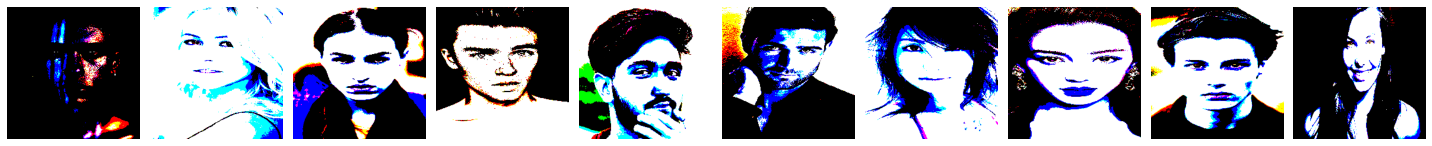

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [167]:
plotImages(imgs)
print(text_labels)

### 2.2 Creating CNN

In [168]:
model = Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same"),
      MaxPool2D(pool_size=(2,2), strides=2),
      Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same"),
      MaxPool2D(pool_size=(2,2), strides=2),
      Flatten(),
      Dense(units=2, activation="softmax")
])

In [169]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [170]:
model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=5, verbose=2)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


316/316 - 408s - loss: 13.9987 - accuracy: 0.9415 - val_loss: 0.2505 - val_accuracy: 0.9141 - 408s/epoch - 1s/step
Epoch 2/5
316/316 - 394s - loss: 0.1310 - accuracy: 0.9712 - val_loss: 0.2032 - val_accuracy: 0.9458 - 394s/epoch - 1s/step
Epoch 3/5
316/316 - 392s - loss: 0.0332 - accuracy: 0.9889 - val_loss: 0.2300 - val_accuracy: 0.9467 - 392s/epoch - 1s/step
Epoch 4/5
316/316 - 395s - loss: 0.0409 - accuracy: 0.9880 - val_loss: 0.2164 - val_accuracy: 0.9520 - 395s/epoch - 1s/step
Epoch 5/5
316/316 - 396s - loss: 0.0683 - accuracy: 0.9842 - val_loss: 0.2407 - val_accuracy: 0.9551 - 396s/epoch - 1s/step


In [171]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

#### 2.2.1 Ploting confusion matrix

In [183]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2006  103]
 [ 155    5]]


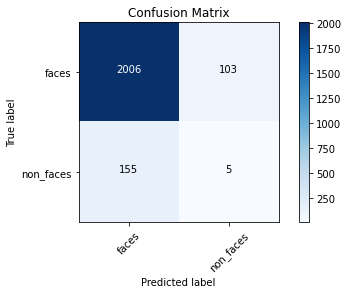

In [184]:
cm_plot_labels = ['faces','non_faces']
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')